In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

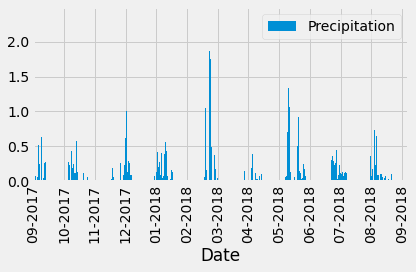

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = dt.date(2017,8,23)

previous_year = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, func.avg(Measurement.prcp)]
year_averages = session.query(*sel).\
    filter(Measurement.date >= previous_year).filter(Measurement.date <= last_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

year_averages
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(year_averages, columns=['Date', 'Precipitation'])
precipitation_df = precipitation_df.set_index(['Date'])

# Sort the dataframe by date
precipitation_df.sort_values(['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot.bar(rot = 90)
plt.xticks(np.arange(0,365,30),['09-2017','10-2017','11-2017','12-2017','01-2018','02-2018','03-2018','04-2018','05-2018','06-2018','07-2018','08-2018','09-2018'])
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data

#The highest amount of precipitation and its occurence date.
max_precipitation = max(precipitation_df['Precipitation'])
max_date = precipitation_df.loc[precipitation_df['Precipitation'] == max_precipitation]

precipitation = max_date['Precipitation'][0]
date = max_date.index[0]
print(f'The highest precipitation of {round(precipitation,4)} occured on {date}.')

#The lowest amount of precipitation and its occurence date.
precipitation_revised = precipitation_df.loc[precipitation_df['Precipitation']>0]
min_precipitation = min(precipitation_revised['Precipitation'])
min_date = precipitation_df.loc[precipitation_df['Precipitation'] == min_precipitation]

precipitation_min = min_date['Precipitation'][0]
date_min = min_date.index[0]
print(f'The lowest precipitation of {round(precipitation_min,4)} occured on {date_min}.')

#Average and standard deviation of precipitation data. 

mean_precipitation = precipitation_df['Precipitation'].mean()
stdev_precipitation = precipitation_df['Precipitation'].std()
print(f'The average precipitation was {round(mean_precipitation,4)} with a standard deviation of {round(stdev_precipitation,4)}.')

The highest precipitation of 2.38 occured on 2016-09-14.
The lowest precipitation of 0.0014 occured on 2017-02-23.
The average precipitation was 0.1708 with a standard deviation of 0.2957.


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number stations in the dataset
sel = [Measurement.station, func.count(Measurement.station)]
number_stations = session.query(*sel).group_by(Measurement.station).all()

station_df = pd.DataFrame(number_stations, columns=['Station_Name', 'Count'])
station_df


,Station_Name,Count
0,USC00511918,1979
1,USC00513117,2709
2,USC00514830,2202
3,USC00516128,2612
4,USC00517948,1372
5,USC00518838,511
6,USC00519281,2772
7,USC00519397,2724
8,USC00519523,2669


In [36]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_sorted_df = station_df.sort_values(by = 'Count', ascending = False)
station_sorted_df

,Station_Name,Count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [55]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_sorted_df['Station_Name'][0]
sel = [Measurement.station, func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)]
temperature_stations = session.query(*sel).group_by(Measurement.station).all()

temperature_df = pd.DataFrame(temperature_stations, columns=['Station_Name', 'Max Temp', 'Min Temp', 'Average Temp'])

temperature_most_active_df = temperature_df.loc[temperature_df['Station_Name'] == most_active_station]

temperature_most_active_df

,Station_Name,Max Temp,Min Temp,Average Temp
0,USC00511918,87.0,53.0,71.615968


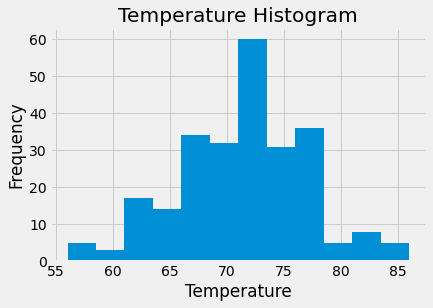

In [102]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, Measurement.tobs]
temperatures = session.query(*sel).filter(Measurement.station == most_active_station).all()
temperatures_df = pd.DataFrame(temperatures, columns = ['Date', 'Temperature']) 
temperatures_sorted_df = temperatures_df.sort_values(by = 'Date', ascending = False)

#Calculating the last date at which a temperature was taken. 
latest_date = dt.date(2015,10,30)

last_year = latest_date - dt.timedelta(days=365)

#Filtering for just the last 12 months of data
temperatures_latest = session.query(*sel).filter(Measurement.station == most_active_station).\
                                                    filter(Measurement.date >= last_year).\
                                                    filter(Measurement.date <= latest_date).all()

temperatures_df = pd.DataFrame(temperatures_latest, columns = ['Date', 'Temperature'])

#Creating a histogram
temperatures_df.hist(bins = 12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title('Temperature Histogram')
plt.show()

# Close session

In [103]:
# Close Session
session.close()